In [100]:
# Application of Self-Organizing Maps (SOM) to Form-finding
# Code developed by Vahid Moosavi (sevamoo@gmail.com) and adapted by Pierluigi D'Acunto (pierluigi.dacunto@tum.de)

# AAG2020 Workshop 4: Structural Form-finding with Machine Learning 
# 26.-27.04.2021

# Related publication:
# @article{doi:10.1177/1478077120943062,
# author = {Karla Saldana Ochoa and Patrick Ole Ohlbrock and Pierluigi D’Acunto and Vahid Moosavi},
# title ={Beyond typologies, beyond optimization: Exploring novel structural forms at the interface of human and machine intelligence},
# journal = {International Journal of Architectural Computing},
# doi = {10.1177/1478077120943062},}

In [101]:
# Import libraries

import pandas as pd
import numpy as np
import glob
import scipy
import sompylib.sompy as SOM
import math
from time import time
import random
import pathlib
import matplotlib.pyplot as plt

In [102]:
path = str(pathlib.Path().absolute())

#path = r'C:/Users/xxxx/Desktop/ML_AAG/'

In [103]:
# Read CSV file and create DataFrame

data = pd.read_csv(path + "\\CEM\\Data\\210425_data_00_CEM.csv", header=None)

data.head(10)     # show first 10 entries of DataFrame

0      1      2      3     4     5     6     7     8            9     ...  \
0  10.0  176.0  160.0  240.0   3.0   4.0   0.0   0.0 -10.0  45397.06771  ...   
1  10.0  176.0  160.0  240.0   3.0   4.0   0.0   0.0 -10.0  45397.06771  ...   
2  10.0  176.0  160.0  240.0   4.0   5.0   0.0   0.0 -10.0  44742.53072  ...   
3  10.0  176.0  160.0  240.0   5.0   4.0   0.0   0.0 -10.0  41789.94294  ...   
4  10.0  176.0  160.0  240.0   4.0   5.0   0.0   0.0 -10.0  40820.66666  ...   
5  10.0  176.0  160.0  240.0   4.0   4.0   0.0   0.0 -10.0  44728.12213  ...   
6  10.0  176.0  160.0  240.0   4.0   5.0   0.0   0.0 -10.0  41693.12072  ...   
7  10.0  176.0  160.0  240.0   3.0   3.0   0.0   0.0 -10.0  40195.79966  ...   
8  10.0  176.0  160.0  240.0   4.0   4.0   0.0   0.0 -10.0  41058.53471  ...   
9  10.0  176.0  160.0  240.0   4.0   4.0   0.0   0.0 -10.0  42233.06386  ...   

   1338  1339  1340  1341  1342  1343  1344  1345  1346  1347  
0  -5.0  -5.0   5.0  -5.0  -5.0   5.0  -5.0  -5.0  -5.0  -5.0  
1  -5.0  -5.0   5.0  -5.0  -5.0   5.0  -5.0  -5.0  -5.0  -5.0  
2   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0  
3   5.0  -5.0   5.0   5.0   5.0   5.0  -5.0   5.0   5.0  -5.0  
4   5.0  -5.0   5.0  -5.0  -5.0   5.0  -5.0   5.0   5.0  -5.0  
5   5.0   5.0   5.0  -5.0  -5.0   5.0   5.0   5.0   5.0   5.0  
6  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  
7  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  
8   5.0   5.0   5.0  -5.0  -5.0   5.0   5.0   5.0   5.0   5.0  
9  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  -5.0  

[10 rows x 1348 columns]

In [104]:
# Get general DataFrame info
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6261 entries, 0 to 6260
Columns: 1348 entries, 0 to 1347
dtypes: float64(1348)
memory usage: 64.4 MB


In [105]:
# Get DataFrame size
data.shape

(6261, 1348)

In [106]:
# Describe DataFrame structure based on features
    
# number of floors -> nF (1) input
# number of nodes -> nN (1) output
# number of trail edges -> nT (1) output
# number of deviation edges -> nD (1) output
# grid size X -> gridX (1) input
# grid size Y -> gridY (1) input
# load X -> loadX (1) input
# load Y -> loadY (1) input
# load Z -> loadZ (1) input
# load path -> totLP (1) output

# floor heights -> hFl (nF) input
# nodes position X -> posX (nN) output
# nodes position Y -> posX (nN) output
# nodes position Z -> posX (nN) output
# trail lenghts -> traLen (nT) output
# trail magnitudes -> traMag (nT) output
# deviation lenghts -> devLen (nD) output
# deviation magnitudes -> devMag (nD) input

In [107]:
# Extract constants

nF = int(data.iloc[0][0])    # number of floors
nN = int(data.iloc[0][1])     # number of nodes
nT = int(data.iloc[0][2])    # number of trail edges
nD = int(data.iloc[0][3])    # number of deviation edges

In [108]:
nT

160

In [109]:
# Generate labels for columns in DataFrame

label_columns_fix = ["nF","nN","nT","nD","gridX","gridY","loadX","loadY","loadZ","totLP"]

nX = len(label_columns_fix)    # number of fixed entries]

label_columns = label_columns_fix[:]
label_columns.extend(["hFl_" + str(i) for i in range(nF)])
label_columns.extend(["posX_" + str(i) for i in range(nN)])
label_columns.extend(["posY_" + str(i) for i in range(nN)])
label_columns.extend(["posZ_" + str(i) for i in range(nN)])    
label_columns.extend(["traLen_" + str(i) for i in range(nT)])
label_columns.extend(["traMag_" + str(i) for i in range(nT)])
label_columns.extend(["devLen_" + str(i) for i in range(nD)])
label_columns.extend(["devMag_" + str(i) for i in range(nD)])

data.columns = label_columns

In [110]:
# Remove NaN from DataFrame

data = data.dropna()

In [111]:
data.shape

(6261, 1348)

In [112]:
# Calculate statistics (Min, Max, Mean, Standard Deviation, Skewness, Kurtosis) per type (Floor Height, Node, Trail, Deviation)

from numpy import mean
from numpy import std
from scipy.stats import skew
from scipy.stats import kurtosis

# Convert initial DataFrame to Numpy 2D array
data_arr = data.values[:]

# Initialize list of list where initial variable features are replaced by their corresponding statistics
data_flat_listlist = []


# Iterate through each row of the array (i.e. each row of the DataFrame)

for i in range(len(data_arr)): 
    
    # Calculate statistics per feature
    p0 = nX
    p1 = p0 + nF
    hFl_arr = data_arr[i][p0:p1]
    hFl_min = hFl_arr.min()
    hFl_max = hFl_arr.max()
    hFl_mean = mean(hFl_arr)
    hFl_std = std(hFl_arr)
    hFl_skew = skew(hFl_arr)
    hFl_kurt = kurtosis(hFl_arr)
    
    p0 = p1
    p1 = p0 + nN
    posX_arr = data_arr[i][p0:p1]
    posX_min = posX_arr.min()
    posX_max = posX_arr.max()
    posX_mean = mean(posX_arr)
    posX_std = std(posX_arr)
    posX_skew = skew(posX_arr)
    posX_kurt = kurtosis(posX_arr)

    p0 = p1
    p1 = p0 + nN
    posY_arr = data_arr[i][p0:p1]
    posY_min = posY_arr.min()
    posY_max = posY_arr.max()
    posY_mean = mean(posY_arr)
    posY_std = std(posY_arr)
    posY_skew = skew(posY_arr)
    posY_kurt = kurtosis(posY_arr)    

    p0 = p1
    p1 = p0 + nN
    posZ_arr = data_arr[i][p0:p1]
    posZ_min = posZ_arr.min()
    posZ_max = posZ_arr.max()
    posZ_mean = mean(posZ_arr)
    posZ_std = std(posZ_arr)
    posZ_skew = skew(posZ_arr)
    posZ_kurt = kurtosis(posZ_arr)

    p0 = p1
    p1 = p0 + nT
    traLen_arr = data_arr[i][p0:p1]
    traLen_min = traLen_arr.min()
    traLen_max = traLen_arr.max()
    traLen_mean = mean(traLen_arr)
    traLen_std = std(traLen_arr)
    traLen_skew = skew(traLen_arr)
    traLen_kurt = kurtosis(traLen_arr) 
           
    p0 = p1
    p1 = p0 + nT
    traMag_arr = data_arr[i][p0:p1]
    traMag_min = traMag_arr.min()
    traMag_max = traMag_arr.max()
    traMag_mean = mean(traMag_arr)
    traMag_std = std(traMag_arr)
    traMag_skew = skew(traMag_arr)
    traMag_kurt = kurtosis(traMag_arr)
    
    p0 = p1
    p1 = p0 + nD
    devLen_arr = data_arr[i][p0:p1]
    devLen_min = devLen_arr.min()
    devLen_max = devLen_arr.max()
    devLen_mean = mean(devLen_arr)
    devLen_std = std(devLen_arr)
    devLen_skew = skew(devLen_arr)
    devLen_kurt = kurtosis(devLen_arr) 
           
    p0 = p1
    p1 = p0 + nD
    devMag_arr = data_arr[i][p0:p1]
    devMag_min = devMag_arr.min()
    devMag_max = devMag_arr.max()
    devMag_mean = mean(devMag_arr)
    devMag_std = std(devMag_arr)
    devMag_skew = skew(devMag_arr)
    devMag_kurt = kurtosis(devMag_arr)

    # Assemble flattened features in an array
    data_flat_list = [
                        hFl_min, hFl_max, hFl_mean, hFl_std, hFl_skew, hFl_kurt,
                        posX_min, posX_max, posX_mean, posX_std, posX_skew, posX_kurt,
                        posY_min, posY_max, posY_mean, posY_std, posY_skew, posY_kurt,
                        posZ_min, posZ_max, posZ_mean, posZ_std, posZ_skew, posZ_kurt,
                        traLen_min, traLen_max, traLen_mean, traLen_std, traLen_skew, traLen_kurt,
                        traMag_min, traMag_max, traMag_mean, traMag_std, traMag_skew, traMag_kurt,
                        devLen_min, devLen_max, devLen_mean, devLen_std, devLen_skew, devLen_kurt,
                        devMag_min, devMag_max, devMag_mean, devMag_std, devMag_skew, devMag_kurt,
                        ]
    
    data_flat_listlist.append(data_flat_list)
                       
# Convert list of list into DataFrame
data_flat = pd.DataFrame.from_records(data_flat_listlist)
data_flat.index = data.index

label_columns = [
                "hFl_min", "hFl_max", "hFl_mean", "hFl_std", "hFl_skew", "hFl_kurt",
                "posX_min", "posX_max", "posX_mean", "posX_std", "posX_skew", "posX_kurt",
                "posY_min", "posY_max", "posY_mean", "posY_std", "posY_skew", "posY_kurt",
                "posZ_min", "posZ_max", "posZ_mean", "posZ_std", "posZ_skew", "posZ_kurt",
                "traLen_min", "traLen_max", "traLen_mean", "traLen_std", "traLen_skew", "traLen_kurt",
                "traMag_min", "traMag_max", "traMag_mean", "traMag_std", "traMag_skew", "traMag_kurt",
                "devLen_min", "devLen_max", "devLen_mean", "devLen_std", "devLen_skew", "devLen_kurt",
                "devMag_min", "devMag_max", "devMag_mean", "devMag_std", "devMag_skew", "devMag_kurt",
                ]

data_flat.columns = label_columns

In [113]:
data_flat

hFl_min  hFl_max  hFl_mean   hFl_std  hFl_skew  hFl_kurt  posX_min  \
0         4.0      5.0      4.55  0.415331 -0.188430 -1.526150 -7.054204   
1         4.0      5.0      4.55  0.415331 -0.188430 -1.526150 -7.054204   
2         4.0      5.0      4.60  0.374166 -0.343622 -1.153061 -2.057059   
3         4.0      5.0      4.45  0.350000  0.139942 -0.960433 -1.601039   
4         4.0      5.0      4.40  0.435890  0.398459 -1.567867 -0.658245   
...       ...      ...       ...       ...       ...       ...       ...   
6256      4.0      5.0      4.55  0.415331 -0.188430 -1.526150 -1.291284   
6257      4.0      5.0      4.65  0.390512 -0.579314 -1.135716  0.000000   
6258      4.0      5.0      4.75  0.335410 -0.993808 -0.222222 -1.062194   
6259      4.0      5.0      4.70  0.331662 -0.657843 -0.628099  0.000000   
6260      4.0      5.0      4.50  0.447214  0.000000 -1.750000 -1.177265   

       posX_max  posX_mean  posX_std  ...  devLen_mean  devLen_std  \
0     16.054204        4.5  4.119788  ...     4.536025    2.989699   
1     16.054204        4.5  4.119788  ...     4.536025    2.989699   
2     14.057059        6.0  5.033620  ...     6.091409    3.168350   
3     16.601039        7.5  6.171292  ...     4.922966    2.629767   
4     12.658245        6.0  4.587903  ...     4.859395    1.717117   
...         ...        ...       ...  ...          ...         ...   
6256  10.291284        4.5  3.492122  ...     3.084202    1.411266   
6257  12.000000        6.0  4.230246  ...     3.886011    1.727813   
6258  10.062194        4.5  3.478089  ...     3.801530    0.863508   
6259  12.000000        6.0  4.100507  ...     4.268739    1.861079   
6260  16.177265        7.5  5.456929  ...     4.674045    1.640282   

      devLen_skew  devLen_kurt  devMag_min  devMag_max  devMag_mean  \
0        1.828686     3.097948        -5.0         5.0    -0.790167   
1        1.828686     3.097948        -5.0         5.0    -0.790167   
2        0.983029     0.754141        -4.5         5.0     0.343667   
3        2.729520     9.451360        -5.0         5.0     0.520167   
4        0.348361     1.432775        -5.0         5.0     0.053500   
...           ...          ...         ...         ...          ...   
6256     0.847641     0.254174        -5.0         5.0     0.579500   
6257     0.894043     1.595373        -5.0         5.0     0.553500   
6258     0.103780    -0.963361        -5.0         5.0     0.312833   
6259     1.342504     3.114848        -5.0         4.5    -0.979833   
6260     0.393389     0.818221        -5.0         5.0     0.153500   

      devMag_std  devMag_skew  devMag_kurt  
0       2.727297     0.182518    -1.021255  
1       2.727297     0.182518    -1.021255  
2       2.849458     0.234968    -1.004073  
3       2.646594     0.022007    -0.565851  
4       2.717475     0.052428    -0.569931  
...          ...          ...          ...  
6256    2.188430     0.249080    -0.152824  
6257    2.483681    -0.302699    -0.283924  
6258    2.442269     0.185251    -0.090098  
6259    2.562218    -0.048744    -0.841782  
6260    2.294335    -0.186521    -0.038541  

[6261 rows x 48 columns]

In [114]:
data_flat = pd.concat([data[label_columns_fix], data_flat], axis=1)

In [115]:
# Save labelled flattened DataFrame as CSV file

data_flat.to_csv("CEM/210425_data_flat_CEM.csv")

In [116]:
# Filter DataFrame 1

traMag_max_mask = abs(data_flat['traLen_max']) < abs(data_flat['traLen_max']).quantile(0.9)
data_flat_filter = data_flat[traMag_max_mask].copy()

data_flat_filter.shape

(5634, 58)

In [117]:
# Filter DataFrame 2

devLen_min_mask = abs(data_flat_filter['devLen_min']) > abs(data_flat_filter['devLen_min']).quantile(.1)
data_flat_filter = data_flat_filter[devLen_min_mask].copy()

data_flat_filter.shape

(5070, 58)

In [118]:
# Filter DataFrame 3

totLP_mask = abs(data_flat_filter['totLP']) < abs(data_flat_filter['totLP']).quantile(.9)
data_flat_filter = data_flat_filter[totLP_mask].copy()

data_flat_filter.shape

(4563, 58)

In [119]:
# Update initial DataFrame in compliance with previous filtering on flat DataFrame

data_filter = data[data.index.isin(data_flat_filter.index)]

In [120]:
data_filter.head(30)

nF     nN     nT     nD  gridX  gridY  loadX  loadY  loadZ        totLP  \
3   10.0  176.0  160.0  240.0    5.0    4.0    0.0    0.0  -10.0  41789.94294   
4   10.0  176.0  160.0  240.0    4.0    5.0    0.0    0.0  -10.0  40820.66666   
6   10.0  176.0  160.0  240.0    4.0    5.0    0.0    0.0  -10.0  41693.12072   
7   10.0  176.0  160.0  240.0    3.0    3.0    0.0    0.0  -10.0  40195.79966   
8   10.0  176.0  160.0  240.0    4.0    4.0    0.0    0.0  -10.0  41058.53471   
10  10.0  176.0  160.0  240.0    4.0    3.0    0.0    0.0  -10.0  40776.75387   
11  10.0  176.0  160.0  240.0    3.0    4.0    0.0    0.0  -10.0  41195.59596   
12  10.0  176.0  160.0  240.0    4.0    3.0    0.0    0.0  -10.0  40606.76402   
13  10.0  176.0  160.0  240.0    5.0    3.0    0.0    0.0  -10.0  40837.08527   
14  10.0  176.0  160.0  240.0    5.0    4.0    0.0    0.0  -10.0  42295.65501   
15  10.0  176.0  160.0  240.0    3.0    5.0    0.0    0.0  -10.0  41455.07047   
17  10.0  176.0  160.0  240.0    5.0    4.0    0.0    0.0  -10.0  41676.14770   
18  10.0  176.0  160.0  240.0    3.0    3.0    0.0    0.0  -10.0  42507.95855   
20  10.0  176.0  160.0  240.0    3.0    3.0    0.0    0.0  -10.0  42183.91567   
21  10.0  176.0  160.0  240.0    3.0    4.0    0.0    0.0  -10.0  42126.29211   
22  10.0  176.0  160.0  240.0    5.0    4.0    0.0    0.0  -10.0  40704.67059   
23  10.0  176.0  160.0  240.0    5.0    5.0    0.0    0.0  -10.0  42794.25508   
24  10.0  176.0  160.0  240.0    3.0    3.0    0.0    0.0  -10.0  41503.36653   
25  10.0  176.0  160.0  240.0    4.0    3.0    0.0    0.0  -10.0  39615.09716   
26  10.0  176.0  160.0  240.0    5.0    3.0    0.0    0.0  -10.0  42653.04861   
27  10.0  176.0  160.0  240.0    5.0    4.0    0.0    0.0  -10.0  39708.52622   
28  10.0  176.0  160.0  240.0    3.0    4.0    0.0    0.0  -10.0  42150.58417   
30  10.0  176.0  160.0  240.0    3.0    3.0    0.0    0.0  -10.0  41998.57708   
32  10.0  176.0  160.0  240.0    5.0    4.0    0.0    0.0  -10.0  41755.90442   
33  10.0  176.0  160.0  240.0    3.0    3.0    0.0    0.0  -10.0  40230.78262   
35  10.0  176.0  160.0  240.0    4.0    4.0    0.0    0.0  -10.0  42614.55101   
36  10.0  176.0  160.0  240.0    5.0    5.0    0.0    0.0  -10.0  41852.56417   
37  10.0  176.0  160.0  240.0    4.0    5.0    0.0    0.0  -10.0  42287.02752   
39  10.0  176.0  160.0  240.0    4.0    5.0    0.0    0.0  -10.0  41531.96975   
40  10.0  176.0  160.0  240.0    4.0    4.0    0.0    0.0  -10.0  42309.46431   

    ...  devMag_230  devMag_231  devMag_232  devMag_233  devMag_234  \
3   ...        5.00       -5.00        5.00        5.00        5.00   
4   ...        5.00       -5.00        5.00       -5.00       -5.00   
6   ...       -5.00       -5.00       -5.00       -5.00       -5.00   
7   ...       -5.00       -5.00       -5.00       -5.00       -5.00   
8   ...        5.00        5.00        5.00       -5.00       -5.00   
10  ...        5.00       -5.00       -5.00       -5.00       -5.00   
11  ...       -5.00        5.00       -5.00        5.00        5.00   
12  ...        5.00        5.00       -5.00       -5.00       -5.00   
13  ...        5.00        5.00       -5.00       -5.00       -5.00   
14  ...        0.01        0.01        0.01        0.01        0.01   
15  ...        5.00        5.00        5.00        5.00        5.00   
17  ...        0.01        0.01        0.01        0.01        0.01   
18  ...        0.01        0.01        0.01        0.01        0.01   
20  ...        0.01        0.01        0.01        0.01        0.01   
21  ...       -5.00       -5.00       -5.00       -5.00       -5.00   
22  ...       -5.00       -5.00        5.00        5.00        5.00   
23  ...       -5.00       -5.00        5.00       -5.00       -5.00   
24  ...        5.00       -5.00        5.00       -5.00       -5.00   
25  ...       -5.00        5.00        5.00        5.00        5.00   
26  ...        0.01        0.01        0.01        0.01        0.01   
27 

In [121]:
# Create DataFrame of input variables 

input_features = ["nF","gridX","gridY","loadX","loadY","loadZ"]
input_features.extend(["hFl_" + str(i) for i in range(nF)])
input_features.extend(["devMag_" + str(i) for i in range(nD)])

input_data_filter = data_filter[input_features]    # as DataFrame

input_data_filter_arr = np.array(input_data_filter)    # as Array

In [122]:
input_data_filter

nF  gridX  gridY  loadX  loadY  loadZ  hFl_0  hFl_1  hFl_2  hFl_3  \
3     10.0    5.0    4.0    0.0    0.0  -10.0    4.0    4.0    4.5    4.5   
4     10.0    4.0    5.0    0.0    0.0  -10.0    4.0    4.0    5.0    4.5   
6     10.0    4.0    5.0    0.0    0.0  -10.0    4.0    5.0    4.0    5.0   
7     10.0    3.0    3.0    0.0    0.0  -10.0    4.0    4.0    4.0    5.0   
8     10.0    4.0    4.0    0.0    0.0  -10.0    5.0    4.0    4.5    4.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
6252  10.0    5.0    5.0    0.0    0.0  -10.0    4.0    4.0    4.5    4.0   
6254  10.0    5.0    3.0    0.0    0.0  -10.0    4.5    4.0    4.0    4.0   
6256  10.0    3.0    3.0    0.0    0.0  -10.0    5.0    4.5    4.5    4.0   
6258  10.0    3.0    4.0    0.0    0.0  -10.0    5.0    5.0    4.5    4.5   
6260  10.0    5.0    4.0    0.0    0.0  -10.0    4.0    5.0    5.0    4.0   

      ...  devMag_230  devMag_231  devMag_232  devMag_233  devMag_234  \
3     ...        5.00       -5.00        5.00        5.00        5.00   
4     ...        5.00       -5.00        5.00       -5.00       -5.00   
6     ...       -5.00       -5.00       -5.00       -5.00       -5.00   
7     ...       -5.00       -5.00       -5.00       -5.00       -5.00   
8     ...        5.00        5.00        5.00       -5.00       -5.00   
...   ...         ...         ...         ...         ...         ...   
6252  ...       -5.00       -5.00        5.00        5.00        5.00   
6254  ...       -5.00        5.00       -5.00       -5.00       -5.00   
6256  ...        5.00        5.00       -5.00       -5.00       -5.00   
6258  ...        5.00        5.00       -5.00        5.00        5.00   
6260  ...        0.01        0.01        0.01        0.01        0.01   

      devMag_235  devMag_236  devMag_237  devMag_238  devMag_239  
3           5.00       -5.00        5.00        5.00       -5.00  
4           5.00       -5.00        5.00        5.00       -5.00  
6          -5.00       -5.00       -5.00       -5.00       -5.00  
7          -5.00       -5.00       -5.00       -5.00       -5.00  
8           5.00        5.00        5.00        5.00        5.00  
...          ...         ...         ...         ...         ...  
6252        5.00       -5.00       -5.00       -5.00       -5.00  
6254       -5.00        5.00       -5.00       -5.00        5.00  
6256       -5.00        5.00        5.00        5.00        5.00  
6258       -5.00        5.00        5.00        5.00        5.00  
6260        0.01        0.01        0.01        0.01        0.01  

[4563 rows x 256 columns]

In [123]:
# Calculate statistics (Min, Max, Mean, Standard Deviation, Percentiles) per feature

data_flat_filter_stat = data_flat_filter.describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99])
data_flat_filter_stat

nF      nN      nT      nD        gridX        gridY   loadX  \
count  4563.0  4563.0  4563.0  4563.0  4563.000000  4563.000000  4563.0   
mean     10.0   176.0   160.0   240.0     4.006794     4.004602     0.0   
std       0.0     0.0     0.0     0.0     0.817497     0.815364     0.0   
min      10.0   176.0   160.0   240.0     3.000000     3.000000     0.0   
10%      10.0   176.0   160.0   240.0     3.000000     3.000000     0.0   
20%      10.0   176.0   160.0   240.0     3.000000     3.000000     0.0   
30%      10.0   176.0   160.0   240.0     3.000000     3.000000     0.0   
40%      10.0   176.0   160.0   240.0     4.000000     4.000000     0.0   
50%      10.0   176.0   160.0   240.0     4.000000     4.000000     0.0   
60%      10.0   176.0   160.0   240.0     4.000000     4.000000     0.0   
70%      10.0   176.0   160.0   240.0     5.000000     5.000000     0.0   
80%      10.0   176.0   160.0   240.0     5.000000     5.000000     0.0   
90%      10.0   176.0   160.0   240.0     5.000000     5.000000     0.0   
95%      10.0   176.0   160.0   240.0     5.000000     5.000000     0.0   
99%      10.0   176.0   160.0   240.0     5.000000     5.000000     0.0   
max      10.0   176.0   160.0   240.0     5.000000     5.000000     0.0   

        loadY   loadZ         totLP  ...  devLen_mean   devLen_std  \
count  4563.0  4563.0   4563.000000  ...  4563.000000  4563.000000   
mean      0.0   -10.0  41472.217795  ...     4.245286     1.837185   
std       0.0     0.0   1153.196678  ...     0.625087     0.493153   
min       0.0   -10.0  37578.581780  ...     2.450208     0.461380   
10%       0.0   -10.0  39915.300016  ...     3.425249     1.228618   
20%       0.0   -10.0  40479.350546  ...     3.700407     1.415257   
30%       0.0   -10.0  40867.601612  ...     3.903461     1.549936   
40%       0.0   -10.0  41233.513648  ...     4.070863     1.682329   
50%       0.0   -10.0  41568.092260  ...     4.232403     1.804136   
60%       0.0   -10.0  41864.133804  ...     4.406819     1.925507   
70%       0.0   -10.0  42202.453646  ...     4.589984     2.062554   
80%       0.0   -10.0  42542.840238  ...     4.793106     2.246761   
90%       0.0   -10.0  42968.221156  ...     5.050786     2.505485   
95%       0.0   -10.0  43188.279231  ...     5.285950     2.709779   
99%       0.0   -10.0  43462.108819  ...     5.650873     3.093448   
max       0.0   -10.0  43527.638690  ...     6.560742     4.348666   

       devLen_skew  devLen_kurt   devMag_min   devMag_max  devMag_mean  \
count  4563.000000  4563.000000  4563.000000  4563.000000  4563.000000   
mean      0.575804     1.111854    -4.917379     4.919351     0.037506   
std       0.644547     1.732375     0.221762     0.216748     0.349854   
min      -2.209645    -1.387514    -5.000000     2.000000    -1.463167   
10%      -0.215267    -0.498291    -5.000000     4.500000    -0.404333   
20%       0.036910    -0.212427    -5.000000     5.000000    -0.262167   
30%       0.234486     0.059859    -5.000000     5.000000    -0.153333   
40%       0.401393     0.336235    -5.000000     5.000000    -0.046600   
50%       0.560739     0.660278    -5.000000     5.000000     0.037833   
60%       0.712124     1.028365    -5.000000     5.000000     0.122833   
70%       0.879558     1.465676    -5.000000     5.000000     0.219867   
80%       1.100632     2.146834    -5.000000     5.000000     0.336833   
90%       1.402976     3.271874    -4.500000     5.000000     0.495667   
95%       1.698368     4.556573    -4.500000     5.000000     0.612333   
99%       2.188418     7.489245    -4.000000     5.000000     0.837023   
max       2.828625    13.332143    -3.000000     5.000000     1.228500   

        devMag_std  devMag_skew  devMag_kurt  
count  4563.000000  4563.000000  4563.000000  
mean      2.360251    -0.011193    -0.096381  
std       0.159635     0.204631     0.341568  
min       1.945689    -0.659634    -1.083590  
10%       2.181662    -0.271282    -0.535994  
20%

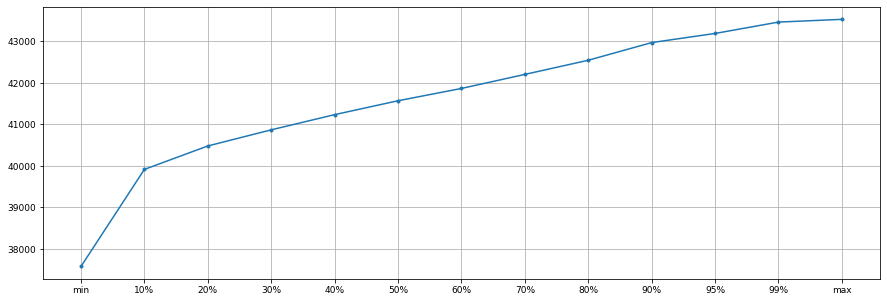

In [124]:
plt.plot(data_flat_filter_stat['totLP'].values[3:],'.-');
ticks = list(data_flat_filter_stat.index.values[3:])
plt.xticks([i for i in range(len(ticks))],ticks)
plt.grid()

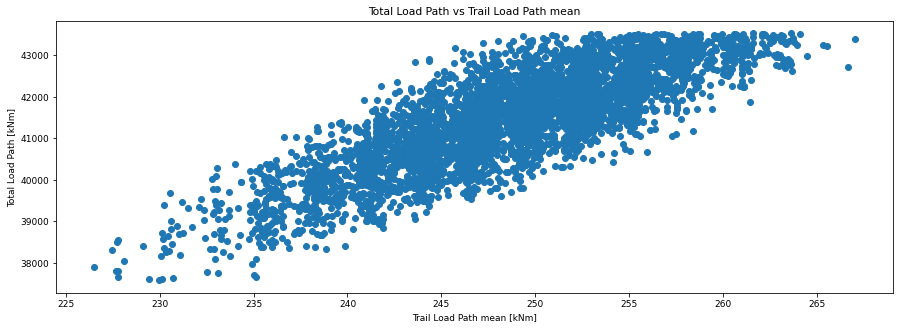

In [125]:
# Plot graph on features correlation

plt.rcParams['figure.figsize'] = [15,5] 
plt.title("Total Load Path vs Trail Load Path mean")
plt.ylabel("Total Load Path [kNm]")
plt.xlabel("Trail Load Path mean [kNm]")

plt.scatter( abs(data_flat_filter['traMag_mean'])*data_flat_filter['traLen_mean'], data_flat_filter['totLP'])
plt.show()

In [126]:
# Import branch-node matrix

branchNode = pd.read_csv(path + "\\CEM\\Topology\\210426_data_00_branch-node_CEM.csv", header=None)

branchNode_arr = branchNode.values[:][0]

In [127]:
branchNode

0     1    2     3    4     5    6     7    8     9    ...    790    791  \
0  0.0  16.0  1.0  17.0  2.0  18.0  3.0  19.0  4.0  20.0  ...  155.0  158.0   

     792    793    794    795    796    797    798    799  
0  148.0  150.0  146.0  149.0  144.0  147.0  145.0  158.0  

[1 rows x 800 columns]

In [128]:
# Create lists of nodes and edges

# Extract list of labels from DataFrame
data_filter_ind = list(data_filter.index.values[:])

# Initialize list of list of nodes and edges
posXYZ_listlist = []
edgeLen_listlist = []
edgeMag_listlist = []


data_filter_arr = data_filter.values[:]

# Iterate through each row of the array

for i in range(len(data_filter_arr)): 

    # Create arrays of nodes
    p0 = nX + nF
    p1 = p0 + 3*nN
    posXYZ_arr = data_filter_arr[i][p0:p1]

    # Create arrays of trail edges    
    p0 = p1
    p1 = p0 + nT
    traLen_arr = data_filter_arr[i][p0:p1]
    
    p0 = p1
    p1 = p0 + nT
    traMag_arr = data_filter_arr[i][p0:p1]
    
    # Create arrays of deviation edges    
    p0 = p1
    p1 = p0 + nD
    devLen_arr = data_filter_arr[i][p0:p1]
    
    p0 = p1
    p1 = p0 + nD
    devMag_arr = data_filter_arr[i][p0:p1]   
    
    
    posXYZ_listlist.append(posXYZ_arr)
    edgeLen_listlist.append( np.concatenate((traLen_arr, devLen_arr), axis=None) )
    edgeMag_listlist.append( np.concatenate((traMag_arr, devMag_arr), axis=None) )

In [129]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

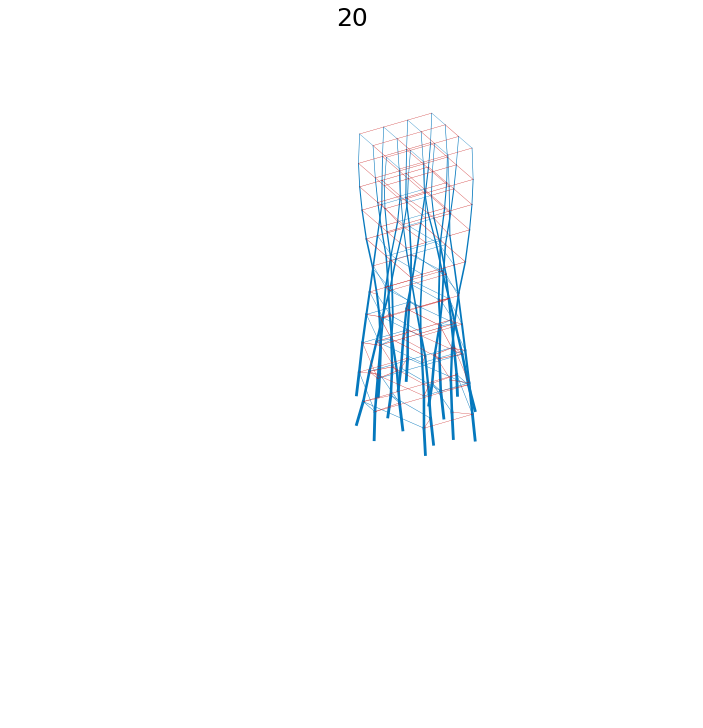

In [130]:
# Plot samples 3D

from mpl_toolkits.mplot3d import Axes3D

f0 = 20    # label of first sample
fN = 1    # number of samples
p0 = data_filter_ind.index(f0)    # get corresponding index of sample in not labelled list

nE = nT + nD

# Define general properties of figure

ncols = 4    # set number of columns for visualization
nrows = math.ceil(fN/ncols)

fig = plt.figure(figsize=(10*ncols,10*nrows), constrained_layout=True)
gs = fig.add_gridspec(nrows, ncols)
gs.update(wspace=0.1, hspace=0.1)    # set the spacing between axes


# Iterate through selected samples

for f in range(p0, p0 + fN):
    
    posXYZ_arr = posXYZ_listlist[f][:]    # nodes coordinates of sample f

    posXYZ_mat = []
    
    # Define array of coordinates
    for i in range(nN):
        x = posXYZ_arr[i]
        y = posXYZ_arr[nN + i]
        z = posXYZ_arr[2*nN + i] 
        posXYZ_mat.append( [x, y, z] )
    coords = np.array(posXYZ_mat)  

    # Set options for subplots
    row = (f-p0) // ncols
    col = (f-p0) % ncols
    ax = fig.add_subplot(gs[row,col], projection='3d')
    ax.set_title(str(data_filter.index[f]), size=25)
    ax.set_aspect('auto')
    ax.axis('off')
    
    # Set view
    ax.set_proj_type('ortho')
    #ax.set_proj_type('persp')
    #ax.view_init(elev=90, azim=-90) # 2D-XY
    #ax.view_init(elev=0, azim=90) # 2D-XZ
    #ax.view_init(elev=0, azim=0) # 2D-YZ
    #ax.view_init(elev=45, azim=45) # 3D-45
    ax.view_init(elev=30, azim=60) # 3D-30
    
    # Create bounding box to simulate equal axes aspect ratio
    bW = 40.0
    ax.plot(0.0, 0.0, 0.0, 'w')
    ax.plot(0.0, 0.0, bW, 'w')
    ax.plot(0.0, bW, 0.0, 'w')
    ax.plot(0.0, bW, bW, 'w')   
    ax.plot(bW, 0.0, 0.0, 'w')
    ax.plot(bW, 0.0, bW, 'w')
    ax.plot(bW, bW, 0.0, 'w')
    ax.plot(bW, bW, bW, 'w')  
   
    # Iterate through edges of sample f
    for edge_i in range(nE):
        
        edge = [ int(branchNode_arr[2*edge_i]), int(branchNode_arr[2*edge_i+1]) ]
        line_color = (5/256,120/256,190/256) if np.sign(edgeMag_listlist[f][edge_i]) < 0 else (200/256,20/256,20/256)
        line_width = 0.3 + np.abs(edgeMag_listlist[f][edge_i]/40)
             
        ax.plot(coords[edge,0], coords[edge,1], coords[edge,2], color = line_color, linewidth = line_width, antialiased=True, alpha = 1.0)

plt.show()

In [131]:
# Select features for SOM training

SOM_features = [
#     'gridX',
#     'gridY',
#     'hFl_min', 
#     'hFl_max', 
#     'hFl_mean', 
#     'hFl_std', 
#     'hFl_skew', 
#     'hFl_kurt',
    'totLP',
    'posX_min',
    'posX_max',    
#     'posX_mean', 
#     'posX_std', 
#     'posX_skew', 
#     'posX_kurt', 
    'posY_min',
    'posY_max',    
#     'posY_mean', 
#     'posY_std', 
#     'posY_skew', 
#     'posY_kurt',
#     'posZ_min',
#     'posZ_max',  
#     'posZ_mean',
#     'posZ_std', 
#     'posZ_skew', 
#     'posZ_kurt',
#     'traLen_min',    
#     'traLen_max',    
#     'traLen_mean',
#     'traLen_std', 
#     'traLen_skew', 
#     'traLen_kurt', 
#     'traMag_min',    
#     'traMag_max',    
#     'traMag_mean',
#     'traMag_std', 
#     'traMag_skew', 
#     'traMag_kurt',
#     'devLen_min',    
#     'devLen_max',    
#     'devLen_mean',
#     'devLen_std', 
#     'devLen_skew', 
#     'devLen_kurt', 
#     'devMag_min',    
#     'devMag_max',    
#     'devMag_mean',
#     'devMag_std', 
#     'devMag_skew', 
#     'devMag_kurt'
    ]

# Create matrix of selected features
XX = data_flat_filter[SOM_features].values[:].astype(float)

In [132]:
# Calculate SOM

msz10 = 40    # define number of SOM-nodes in X directions
msz11 = 40    # define number of SOM-nodes in Y directions

som = SOM.SOM('', XX[:], mapsize = [msz10, msz11], norm_method = 'var', initmethod = 'pca')
som.train(n_job = 1, shared_memory = 'no',verbose = 'on')
som.compname=[SOM_features]

initialization method = pca, initializing..
initialization done in 0.014000 seconds

rough training...
radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 11
epoch: 1 ---> elapsed time:  0.051000, quantization error: 1.451218 
epoch: 2 ---> elapsed time:  0.046000, quantization error: 1.330132 
epoch: 3 ---> elapsed time:  0.048000, quantization error: 1.181740 
epoch: 4 ---> elapsed time:  0.044000, quantization error: 1.065591 
epoch: 5 ---> elapsed time:  0.050000, quantization error: 0.999379 
epoch: 6 ---> elapsed time:  0.045000, quantization error: 0.942156 
epoch: 7 ---> elapsed time:  0.043000, quantization error: 0.883179 
epoch: 8 ---> elapsed time:  0.044000, quantization error: 0.825019 
epoch: 9 ---> elapsed time:  0.046000, quantization error: 0.767125 
epoch: 10 ---> elapsed time:  0.049000, quantization error: 0.705543 
epoch: 11 ---> elapsed time:  0.047000, quantization error: 0.636480 


finetune training...
radius_ini: 1.250000 , radius_final: 1.000000, trainl

In [133]:
# Get distance/s and Best Matching Unit (BMU)/s indices for each sample

dists, bmus = som.find_K_nodes(som.data_raw, K=1)

[8, 4, 4, 6, 3, 2, 4, 4, 2, 10, 3, 6, 4, 4, 4, 4, 4, 9, 8, 4, 7, 6, 7, 3, 5, 6, 3, 3, 7, 0, 5, 5, 7, 9, 7, 4, 7, 3, 6, 8, 0, 5, 0, 2, 3, 0, 5, 1, 0, 0, 0, 0, 3, 1, 2, 5, 0, 2, 2, 3, 2, 2, 3, 2, 0, 3, 3, 1, 2, 0, 7, 2, 3, 2, 1, 3, 1, 2, 2, 2, 6, 1, 4, 3, 1, 0, 3, 0, 0, 6, 1, 5, 3, 5, 0, 3, 3, 4, 2, 2, 4, 2, 2, 2, 2, 1, 1, 1, 7, 0, 4, 3, 7, 7, 3, 5, 1, 1, 5, 9, 5, 3, 3, 6, 0, 0, 10, 0, 4, 4, 5, 6, 0, 5, 0, 2, 2, 5, 1, 3, 2, 5, 2, 2, 4, 3, 3, 5, 6, 0, 1, 2, 2, 5, 2, 3, 4, 3, 1, 7, 7, 2, 4, 3, 0, 1, 6, 0, 3, 5, 3, 0, 7, 4, 0, 2, 0, 3, 5, 2, 1, 4, 3, 3, 6, 4, 1, 2, 4, 0, 1, 5, 5, 2, 2, 3, 4, 4, 0, 6, 7, 2, 4, 5, 0, 1, 4, 2, 0, 4, 7, 3, 5, 0, 5, 4, 3, 0, 2, 6, 2, 4, 2, 4, 1, 4, 4, 3, 8, 0, 7, 2, 5, 6, 2, 8, 0, 5, 3, 8, 4, 3, 2, 0, 4, 5, 4, 2, 2, 0, 0, 0, 4, 0, 4, 1, 2, 1, 0, 0, 4, 0, 0, 5, 4, 3, 2, 0, 2, 0, 2, 8, 3, 3, 7, 0, 5, 4, 3, 2, 9, 2, 8, 0, 2, 5, 4, 0, 4, 4, 5, 4, 2, 2, 0, 0, 3, 3, 7, 2, 1, 7, 6, 0, 1, 3, 3, 7, 8, 0, 5, 1, 1, 5, 3, 0, 9, 2, 1, 6, 8, 4, 1, 1, 6, 1, 2, 7, 1, 1, 2, 3, 3

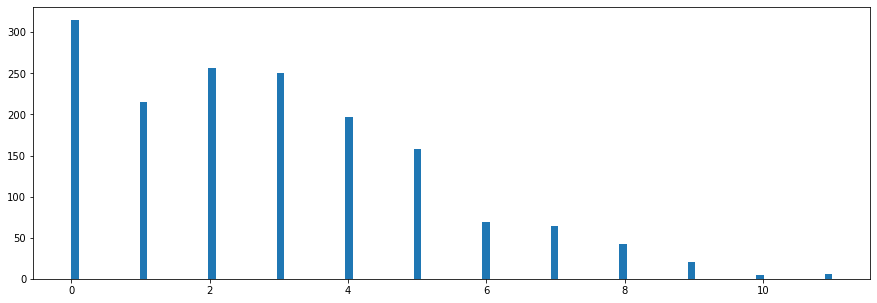

In [134]:
# Calculate number of samples in each SOM-node

n_bmus = [ np.sum(bmus==i) for i in range(som.nnodes) ]

plt.hist(n_bmus,bins=100)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

print(n_bmus)

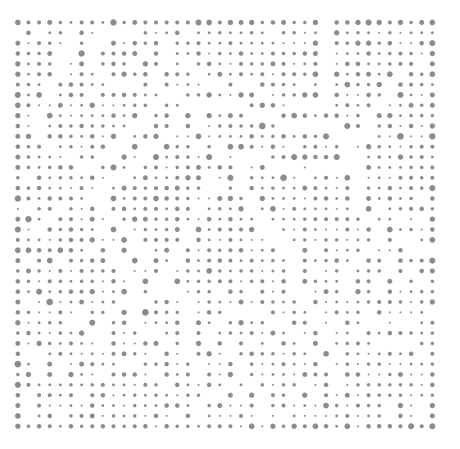

In [135]:
som.hit_map(col='gray')

In [136]:
# Get representative samples per SOM-nodes (samples that are closer to their corresponding BMUs)
sel_samples_SOM = []

for nnode in range(som.nnodes):
    
    # Get all samples per SOM-node
    samples_SOM = np.argwhere(bmus==nnode)[:,0]
    
    # Number of samples per SOM-node
    K = len(samples_SOM)   

    if K >= 1:
        # Sort samples according to distance within each BMU cluster
        DF_tmp = pd.DataFrame()
        DF_tmp['sel_samples_SOM'] = samples_SOM
        DF_tmp['dists'] = dists[samples_SOM]
        DF_tmp = DF_tmp.sort_values(by=['dists'])
        ord_samples_SOM = DF_tmp['sel_samples_SOM'].copy().values[:]     # ordered samples
        sel_sample_SOM = ord_samples_SOM[0]    # representative sample for SOM-node
        sel_samples_SOM.append(sel_sample_SOM)
    else:
        sel_samples_SOM.append(-1)

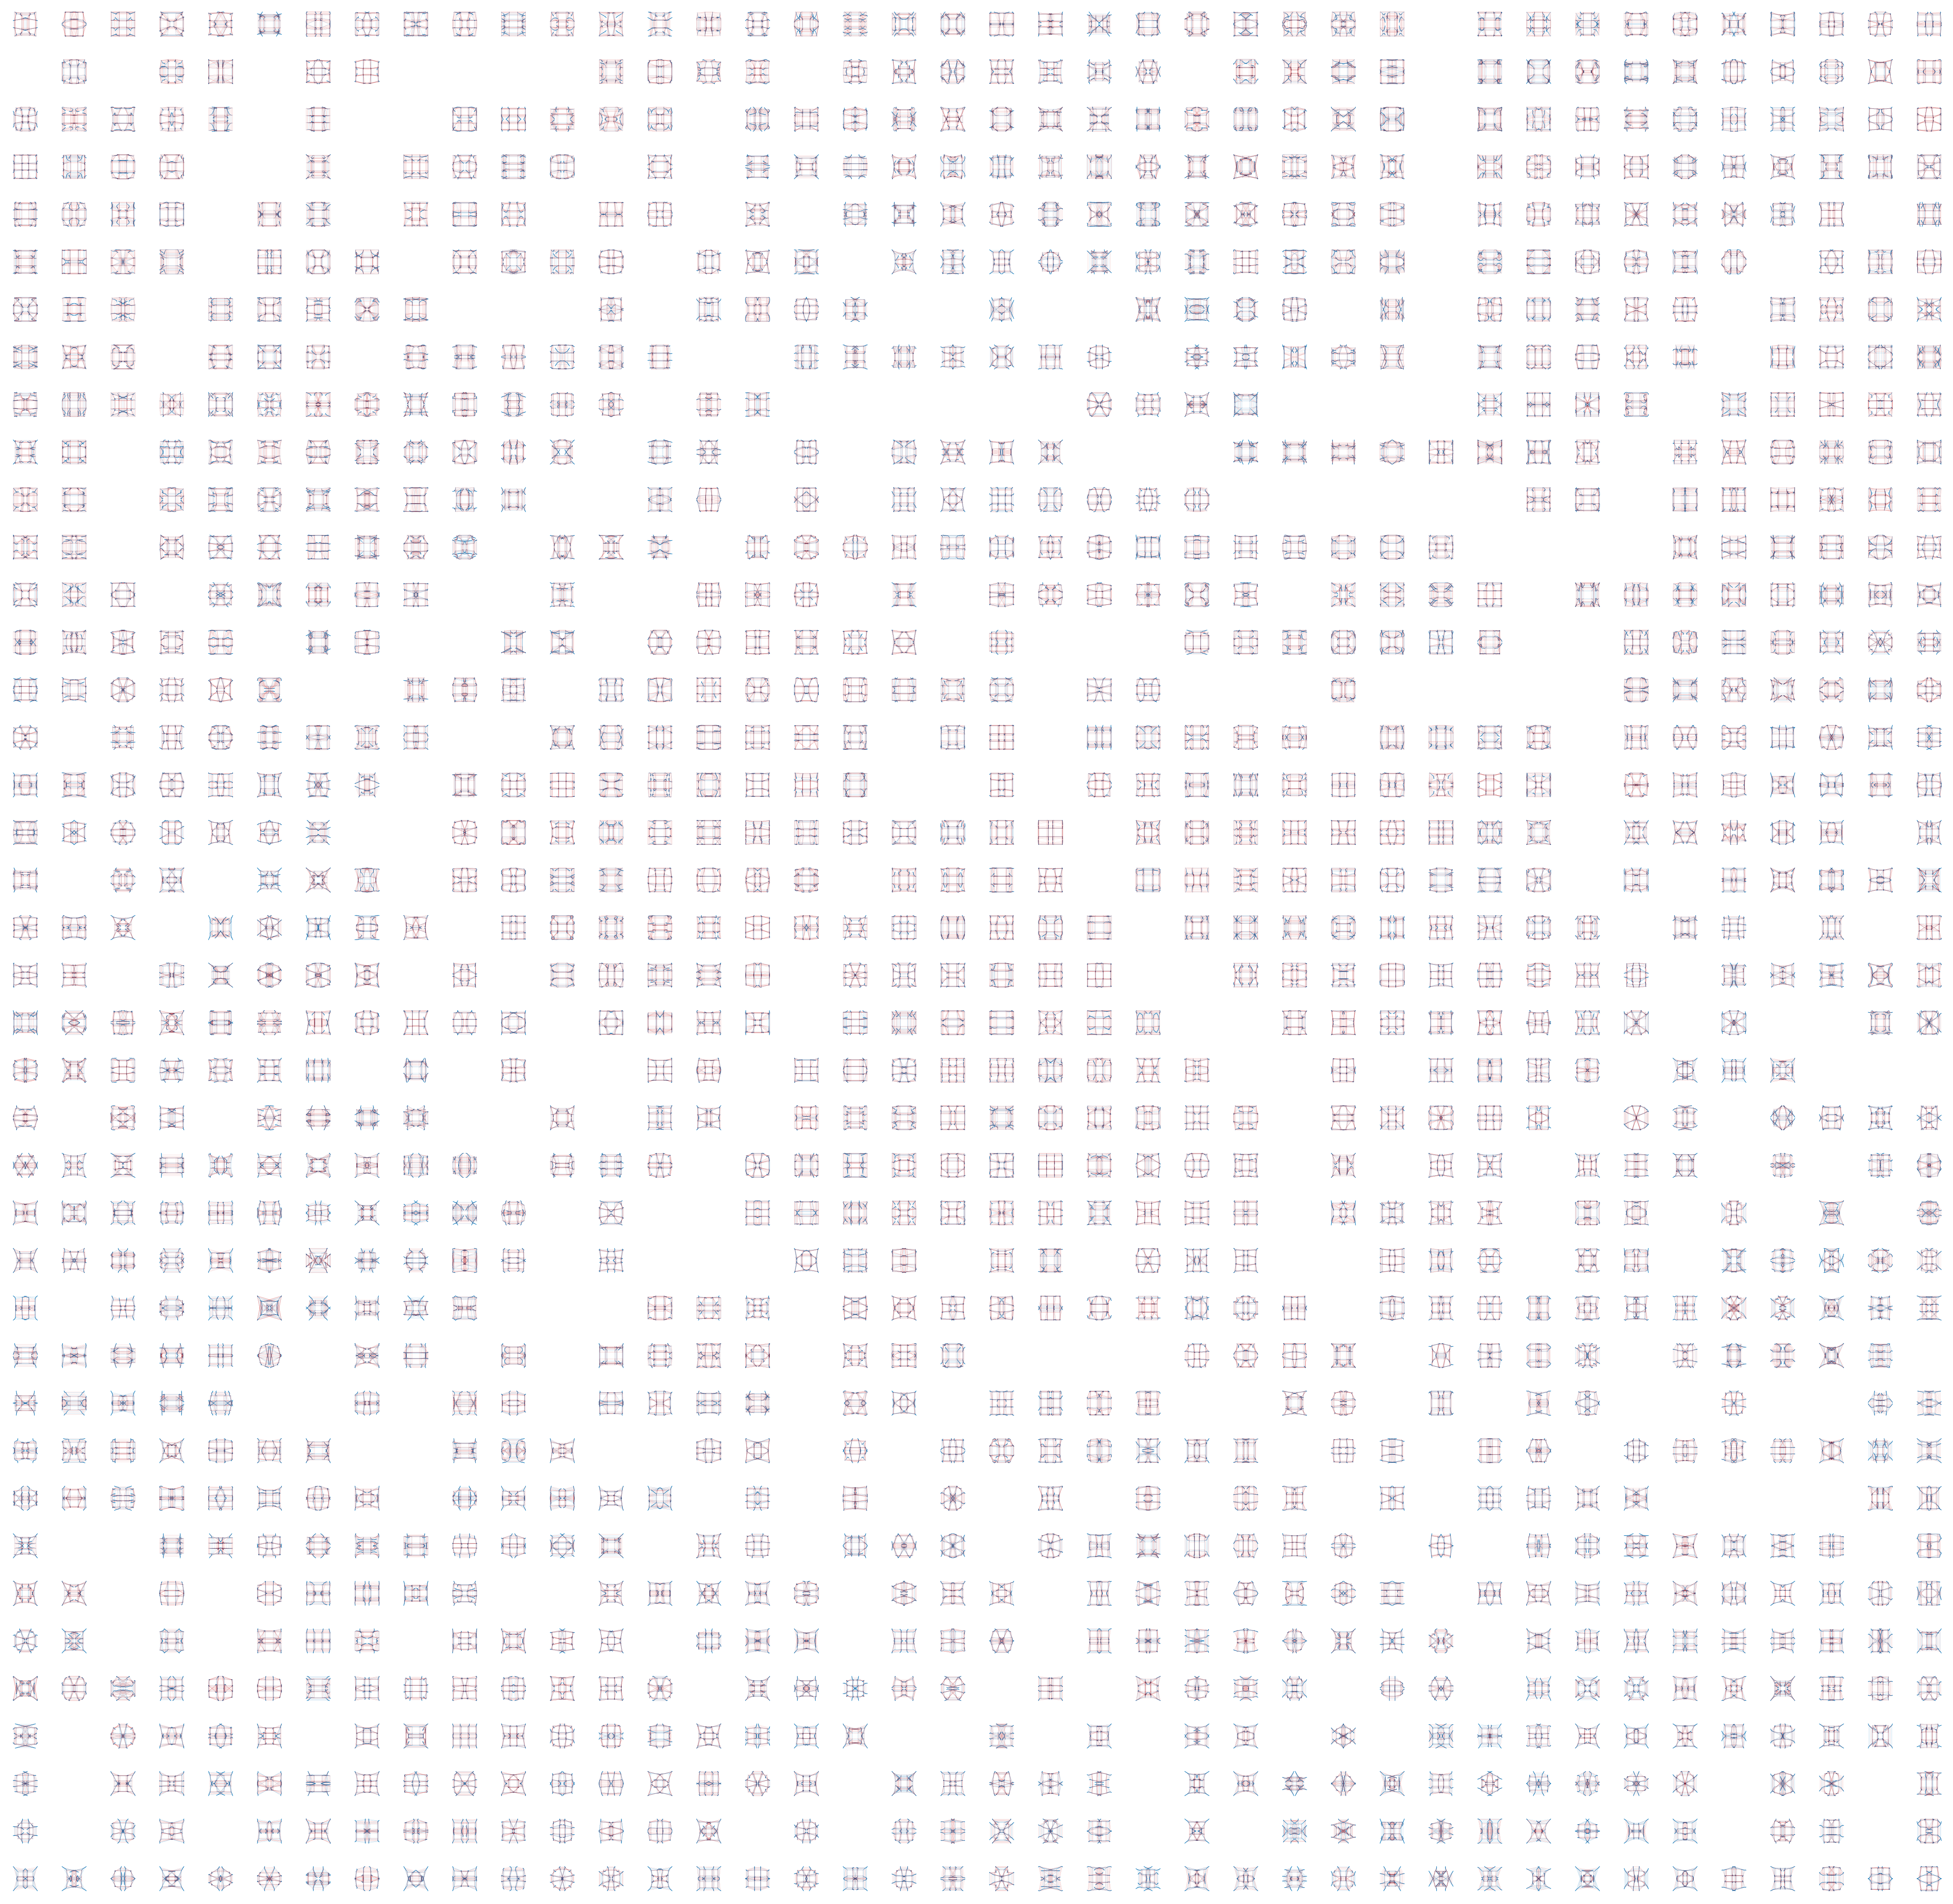

In [137]:
# Plot SOM with representative sample per SOM-node

from mpl_toolkits.mplot3d import Axes3D

nE = nT + nD

# Define general properties of figure

ncols = msz11    # set number of columns for visualization
nrows = msz10    # set number of rows for visualization

fig = plt.figure(figsize=(2*ncols,2*nrows))
gs = fig.add_gridspec(nrows, ncols)
gs.update(wspace=0.1, hspace=0.1)    # set the spacing between axes

    
# Iterate through SOM-nodes to plot representative samples 
for s in range(len(sel_samples_SOM)):

    f = sel_samples_SOM[s]    # representative sample f
    
    if f > -1:              

        posXYZ_arr = posXYZ_listlist[f][:]    # nodes coordinates of sample f
        posXYZ_mat = []

        # Define array of coordinates
        for i in range(nN):
            x = posXYZ_arr[i]
            y = posXYZ_arr[nN + i]
            z = posXYZ_arr[2*nN + i] 
            posXYZ_mat.append( [x, y, z] )
        coords = np.array(posXYZ_mat)  

        # Set options for subplots
        row = s // ncols
        col = s % ncols
        ax = fig.add_subplot(gs[row,col], projection='3d')
#         ax.set_title(str(data_filter.index[f]), size=10)
        ax.set_aspect('auto')
        ax.axis('off')
            
        # Set view
        ax.set_proj_type('ortho')
        #ax.set_proj_type('persp')
        ax.view_init(elev=90, azim=-90) # 2D-XY
        #ax.view_init(elev=0, azim=90) # 2D-XZ
        #ax.view_init(elev=0, azim=0) # 2D-YZ
        #ax.view_init(elev=45, azim=45) # 3D-45
        #ax.view_init(elev=30, azim=60) # 3D-30


        # Iterate through edges of sample f
        for edge_i in range(nE):

            edge = [ int(branchNode_arr[2*edge_i]), int(branchNode_arr[2*edge_i+1]) ]
            line_color = (5/256,120/256,190/256) if np.sign(edgeMag_listlist[f][edge_i]) < 0 else (200/256,20/256,20/256)
            line_width = 0.1 + np.abs(edgeMag_listlist[f][edge_i]/100)

            ax.plot(coords[edge,0], coords[edge,1], coords[edge,2], color = line_color, linewidth = line_width, antialiased=True, alpha = 1.0)                  
       
    else:
        continue
            
plt.show()

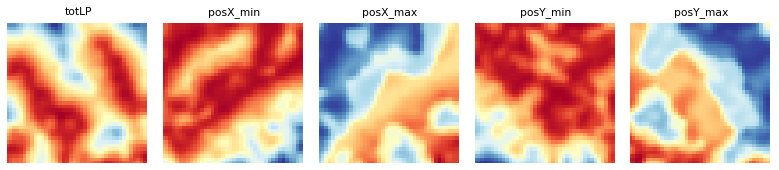

In [138]:
if XX.shape[1] > 100:
    pass
else:
    som.view_map(text_size=9)

In [139]:
# convert BMU index to xy position on SOM

xy_option = som.ind_to_xy(bmus[:,0])
xx = xy_option[:,1]
yy = som.mapsize[0]- xy_option[:,0]

In [140]:
def show_node(node_SOM=0, Measure1='totLP', Measure2='posX_mean'):
    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from mpl_toolkits.mplot3d import Axes3D
    
    # Print index selected SOM-node
    print ('node index: ', node_SOM)

    # Get all samples in selected SOM-node
    samples_SOM = np.argwhere(bmus==node_SOM)[:,0]
       
    # Number of samples in selected SOM-node
    K = len(samples_SOM) 
    print('number samples: ', K)
   
    if K >= 1:
        
        # Define general properties of figure
        ncols = 4    # set number of columns for visualization
        nrows = math.ceil( K / ncols)    # set number of rows for visualization

        fig = plt.figure(figsize=(10*ncols,10*nrows), constrained_layout=True)
        gs = fig.add_gridspec(nrows, ncols)
        gs.update(wspace=0.1, hspace=0.1)    # set the spacing between axes
        
        # Sort samples in SOM_node according to distance within each BMU cluster
        DF_tmp = pd.DataFrame()
        DF_tmp['sel_samples_SOM'] = samples_SOM
        DF_tmp['dists'] = dists[samples_SOM]
        DF_tmp = DF_tmp.sort_values(by=['dists'])
        ord_samples_SOM = DF_tmp['sel_samples_SOM'].copy().values[:]     # ordered samples in selected SOM-node
                         
        # Iterate through ordered samples of selected SOM-node 
        for s in range(len(ord_samples_SOM)):

            f = ord_samples_SOM[s]
            
            posXYZ_arr = posXYZ_listlist[f][:]    # nodes coordinates of sample f

            posXYZ_mat = []

            # Define array of coordinates
            for i in range(nN):
                x = posXYZ_arr[i]
                y = posXYZ_arr[nN + i]
                z = posXYZ_arr[2*nN + i] 
                posXYZ_mat.append( [x, y, z] )
            coords = np.array(posXYZ_mat)  

            # Set options for subplots
            row = s // ncols
            col = s % ncols
            ax = fig.add_subplot(gs[row,col], projection='3d')
            title_ind = data_filter.index[f]
            title_feat_1 = truncate(data_flat_filter[Measure1].iloc[f], 2)
            title_feat_2 = truncate(data_flat_filter[Measure2].iloc[f], 2)
            ax.set_title(str(title_ind) + "  " + str(title_feat_1) + "  " + str(title_feat_2), size=25)
            ax.set_aspect('auto')
            ax.axis('off')

            # Set view
            ax.set_proj_type('ortho')
            #ax.set_proj_type('persp')
            #ax.view_init(elev=90, azim=-90) # 2D-XY
            ax.view_init(elev=0, azim=90) # 2D-XZ
            #ax.view_init(elev=0, azim=0) # 2D-YZ
            #ax.view_init(elev=45, azim=45) # 3D-45
            #ax.view_init(elev=30, azim=60) # 3D-30

            # Create bounding box to simulate equal axes aspect ratio
            bW = 40.0
            ax.plot(0.0, 0.0, 0.0, 'w')
            ax.plot(0.0, 0.0, bW, 'w')
            ax.plot(0.0, bW, 0.0, 'w')
            ax.plot(0.0, bW, bW, 'w')   
            ax.plot(bW, 0.0, 0.0, 'w')
            ax.plot(bW, 0.0, bW, 'w')
            ax.plot(bW, bW, 0.0, 'w')
            ax.plot(bW, bW, bW, 'w')  

            # Iterate through edges of sample f
            for edge_i in range(nE):

                edge = [ int(branchNode_arr[2*edge_i]), int(branchNode_arr[2*edge_i+1]) ]
                line_color = (5/256,120/256,190/256) if np.sign(edgeMag_listlist[f][edge_i]) < 0 else (200/256,20/256,20/256)
                line_width = 0.3 + np.abs(edgeMag_listlist[f][edge_i]/40)

                ax.plot(coords[edge,0], coords[edge,1], coords[edge,2], color = line_color, linewidth = line_width, antialiased=True, alpha = 1.0)
    else:
        print ('not enough data for this node')

node index:  0
number samples:  8


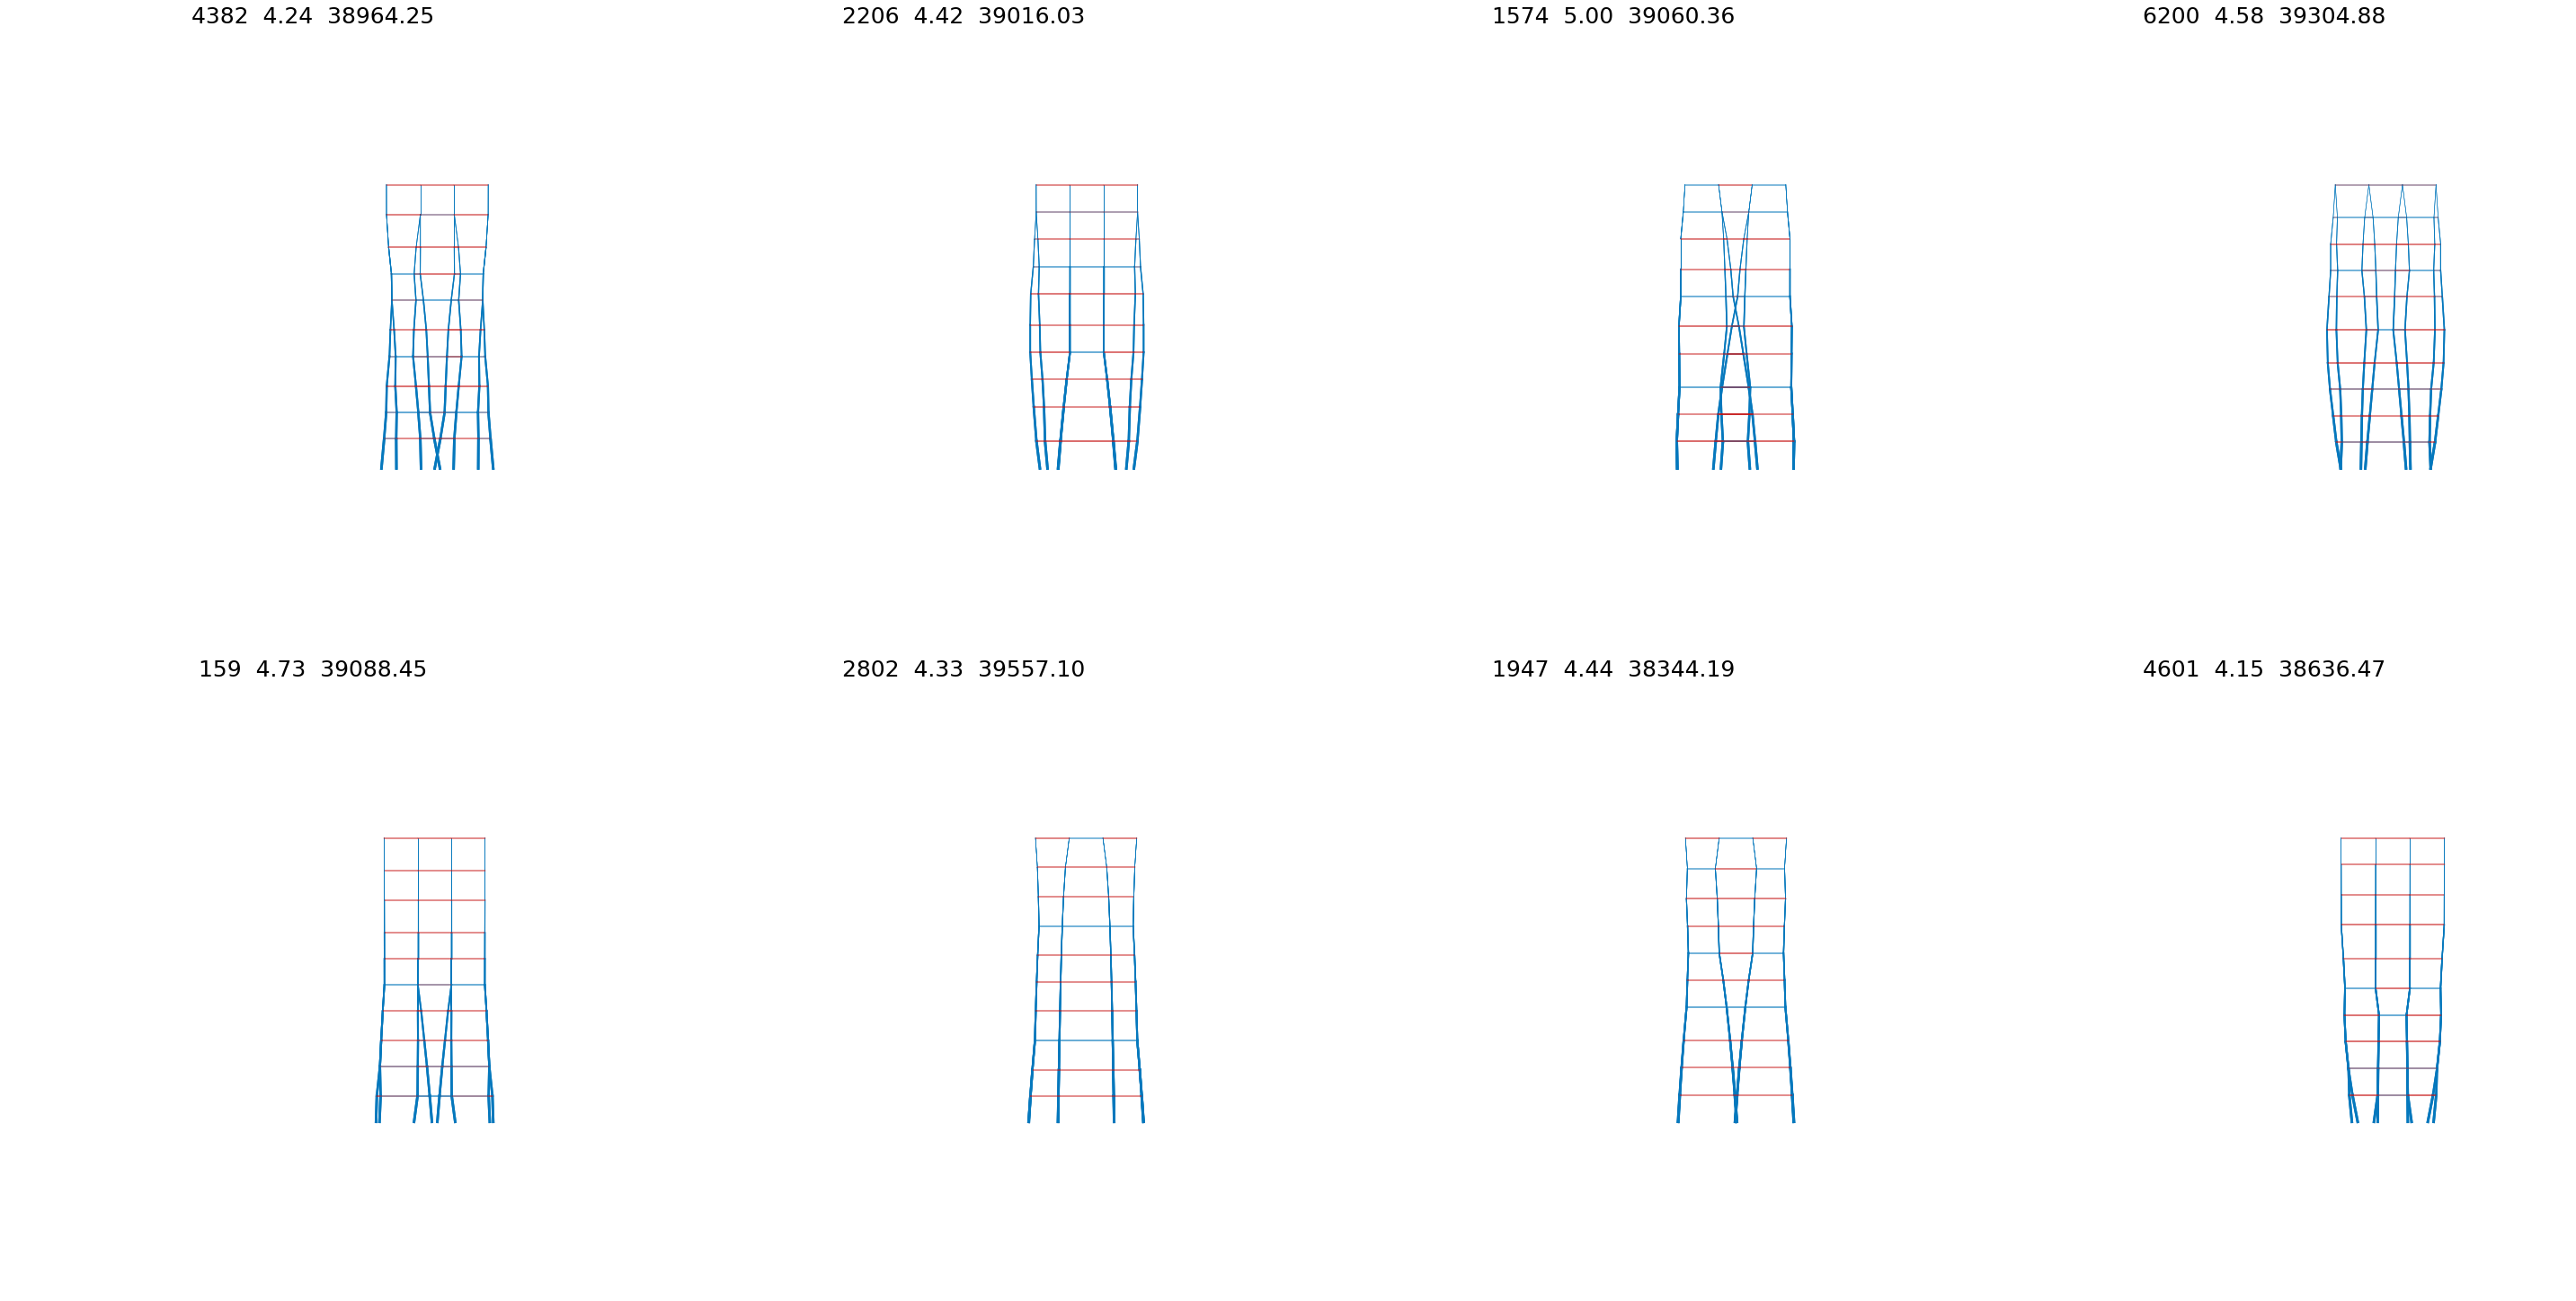

In [141]:
show_node(node_SOM = 0, Measure1='devLen_mean', Measure2='totLP')

node index:  39
number samples:  8


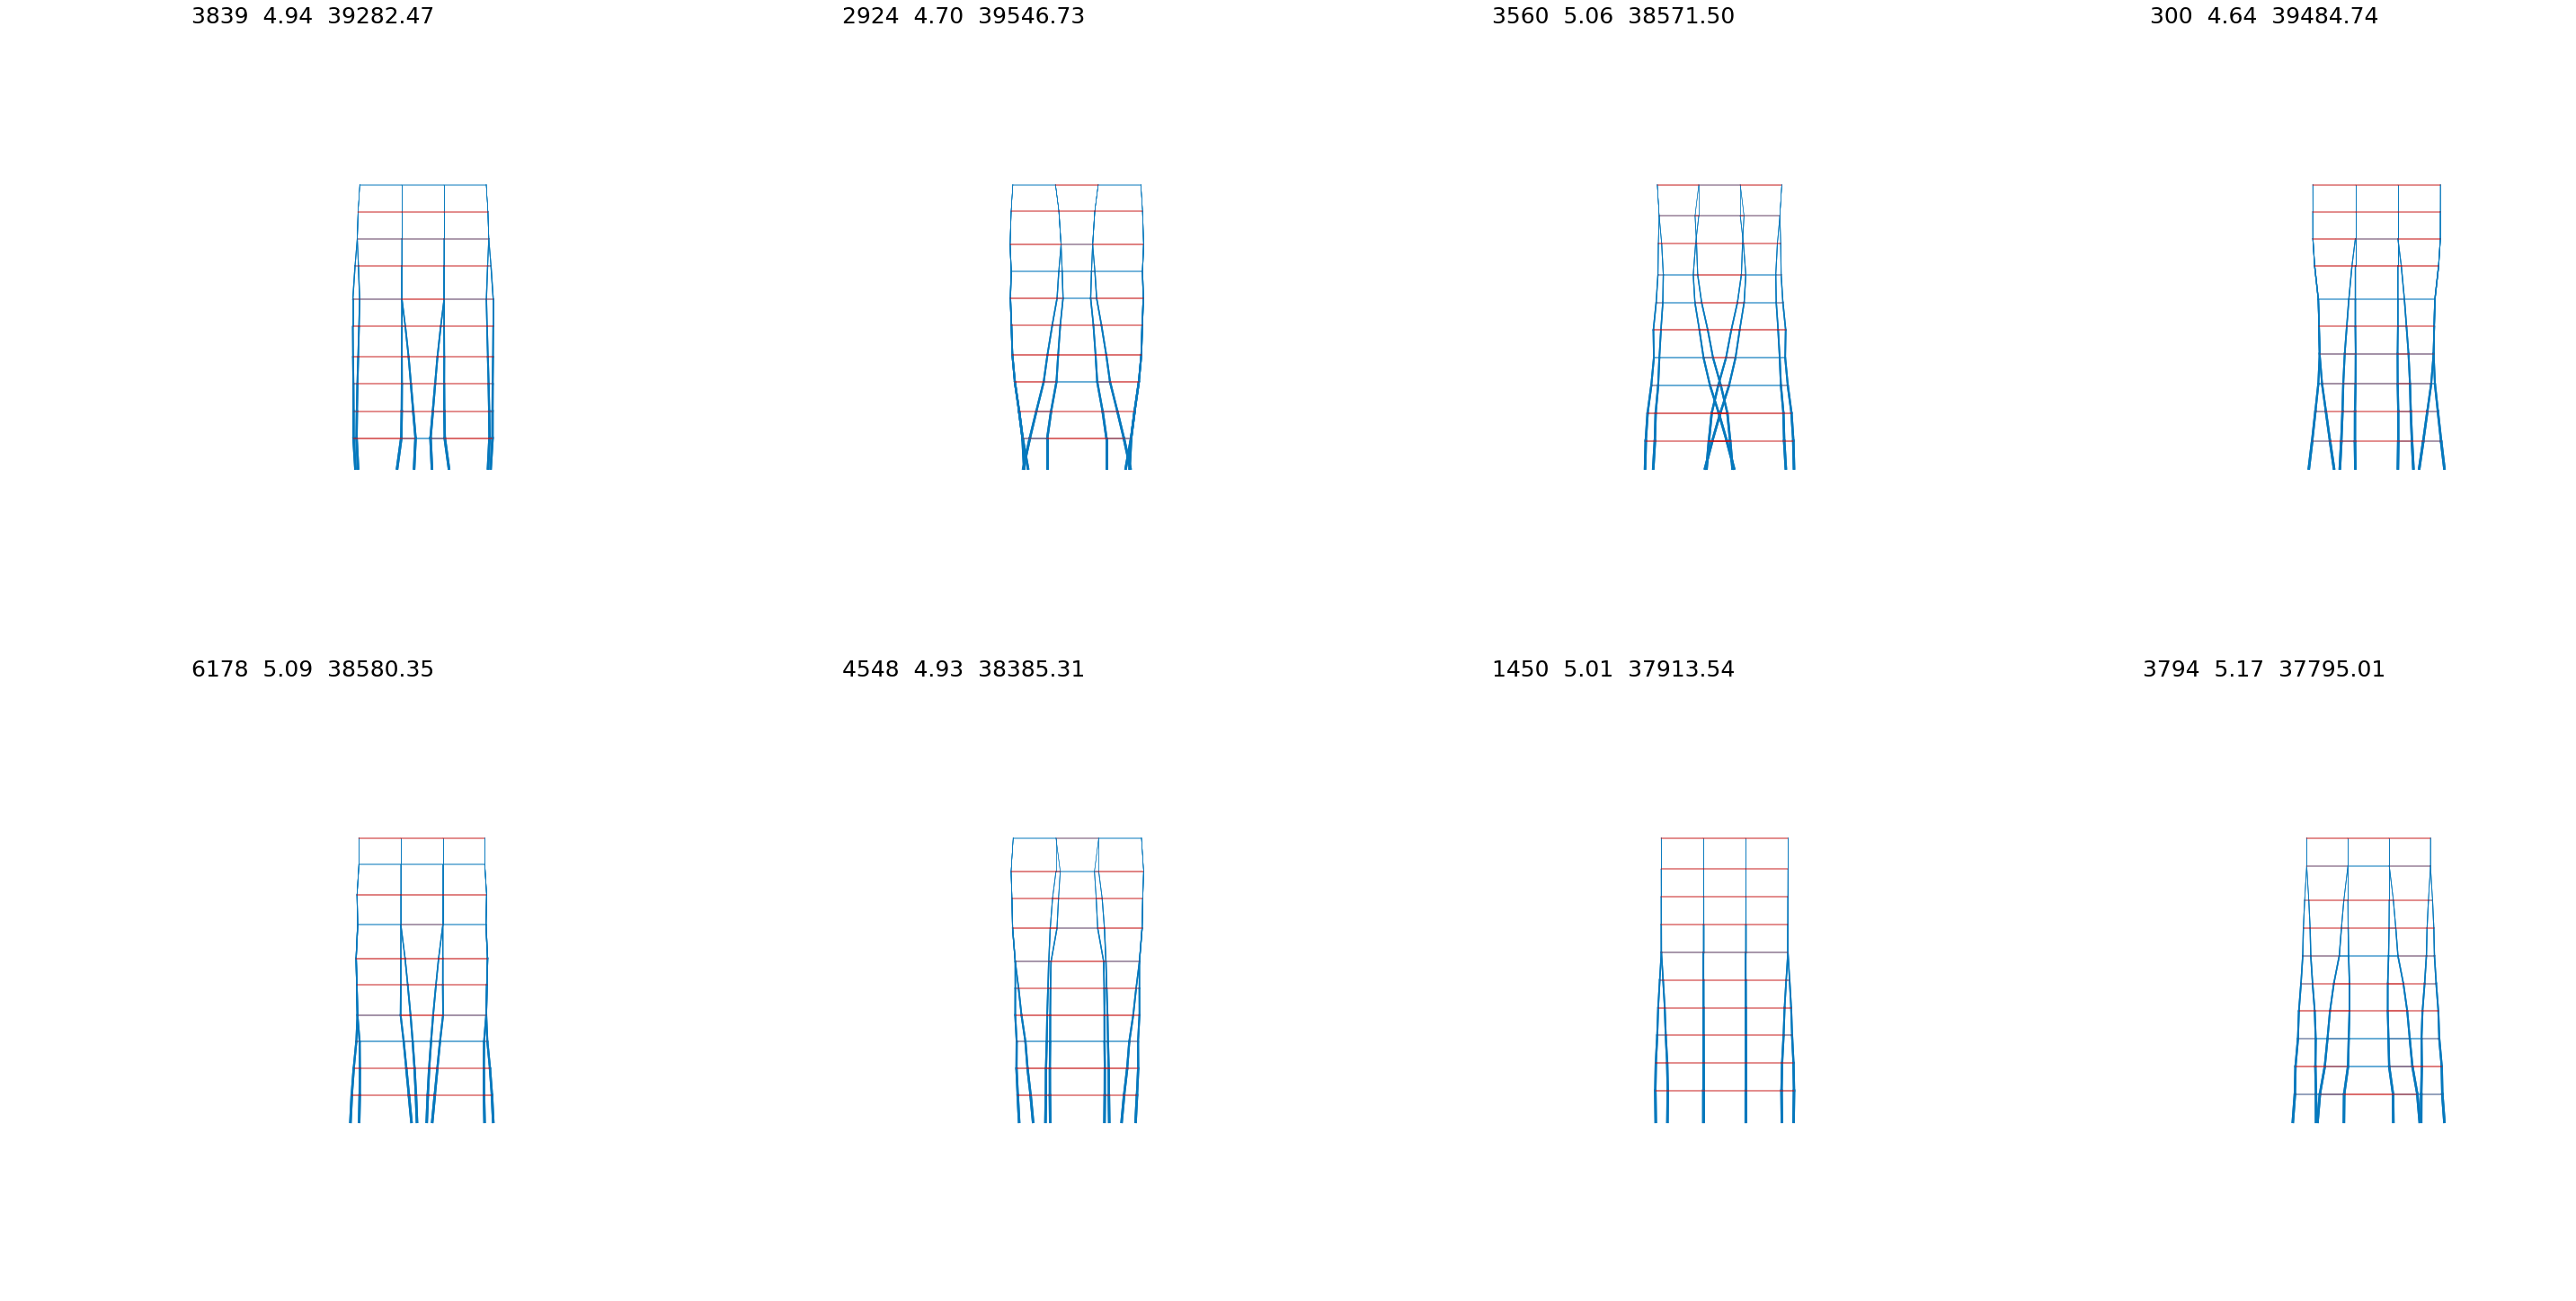

In [142]:
show_node(node_SOM=39, Measure1='devLen_mean', Measure2='totLP')

In [143]:
codebooks = SOM.denormalize_by(som.data_raw, som.codebook)
unq_bmus = np.unique(bmus)
xy_som = som.ind_to_xy(unq_bmus)


def query_nodes_new(Measure1=None, percentRange1=[0,50], Measure2=None, percentRange2=[0,50],
                    Measure3=None, percentRange3=[0,50], plot='Yes'):
    
    from IPython.display import clear_output, Image, display
  
    codebooks = SOM.denormalize_by(som.data_raw,som.codebook)

    DF_som = pd.DataFrame(data=codebooks,columns=list(som.compname[0]))
    percentiles = list(set(percentRange1).union(percentRange2).union(percentRange3))
    percentiles = list(np.sort(percentiles)/100.0)
    som_stat = DF_som.describe(percentiles=percentiles)

    ind_sel_nodes = []
    
    if Measure1 != None and  Measure2 != None and  Measure3 != None:
        ind_sel_nodes = DF_som.loc[
            (DF_som[Measure1] >= som_stat.loc[str(percentRange1[0])+'%'][Measure1])
            &
            (DF_som[Measure1] <= som_stat.loc[str(percentRange1[1])+'%'][Measure1])
            &
            (DF_som[Measure2] >= som_stat.loc[str(percentRange2[0])+'%'][Measure2])
            &
            (DF_som[Measure2] <= som_stat.loc[str(percentRange2[1])+'%'][Measure2])
            &
            (DF_som[Measure3] >= som_stat.loc[str(percentRange3[0])+'%'][Measure3])
            &
            (DF_som[Measure3] <= som_stat.loc[str(percentRange3[1])+'%'][Measure3])
        ].index.values[:]

    if Measure1 != None and Measure2 != None and Measure3 == None:
        ind_sel_nodes = DF_som.loc[
            (DF_som[Measure1] >= som_stat.loc[str(percentRange1[0])+'%'][Measure1])
            &
            (DF_som[Measure1] <= som_stat.loc[str(percentRange1[1])+'%'][Measure1])
            &
            (DF_som[Measure2] >= som_stat.loc[str(percentRange2[0])+'%'][Measure2])
            &
            (DF_som[Measure2] <= som_stat.loc[str(percentRange2[1])+'%'][Measure2])
        ].index.values[:]
    
    if Measure1 != None and  Measure2 == None and Measure3 == None:
        ind_sel_nodes = DF_som.loc[
            (DF_som[Measure1] >= som_stat.loc[str(percentRange1[0])+'%'][Measure1])
            &
            (DF_som[Measure1] <= som_stat.loc[str(percentRange1[1])+'%'][Measure1])
        ].index.values[:] 
    
    if plot=='Yes':
        xy_sel = som.ind_to_xy(ind_sel_nodes)            
        fig = plt.figure(figsize=(20,40))
        plt.rcParams.update({'font.size': 10})

        for i in range(codebooks.shape[1]):

            ax = fig.add_subplot(6,3,i+1)
            col = codebooks[unq_bmus,i]
            mn = col.min()
            mx = col.max()
            col = codebooks[ind_sel_nodes,i]
            x = xy_sel[:,1]*2
            y = som.mapsize[0]-1-xy_sel[:,0]*1
            sc = ax.scatter(x,y,s=200,c=col,cmap=plt.cm.RdYlBu_r,edgecolor='None',vmax=mx,vmin=mn,marker='o',alpha=1.);
            eps = 1
            plt.xlim(x.min()-eps,x.max()+eps)
            plt.ylim(y.min()-eps,y.max()+eps)
            plt.colorbar(sc,shrink=.5,ticks=[mn,(mn+mx)/2.0,mx])
            plt.title(som.compname[0][i])
            plt.tight_layout(pad=0.001, h_pad=0.0, w_pad=0.0)
            plt.xlim(0,som.mapsize[0]-1);
            plt.ylim(0,som.mapsize[1]-1);
            plt.xticks([]);
            plt.yticks([]);
    
    return ind_sel_nodes

In [149]:
# Design Option A

sel_options_A = query_nodes_new(Measure1='posX_min',percentRange1=[0,50], Measure2='posX_max',percentRange2=[0,20],
                                Measure3='totLP',percentRange3=[0,50], plot='No')
print("Selected nodes: " + str(len(sel_options_A)) + "/" + str(msz10*msz11))
print("")
print(sel_options_A)

Selected nodes: 35/1600

[  63   64  100  101  102  103  104  105  139  140  141  177  178  179
  215  216  217  218  254  255  289  290  329  330  331  368  369  370
  371  409  490  763  803  804 1045]


node index:  100
number samples:  4


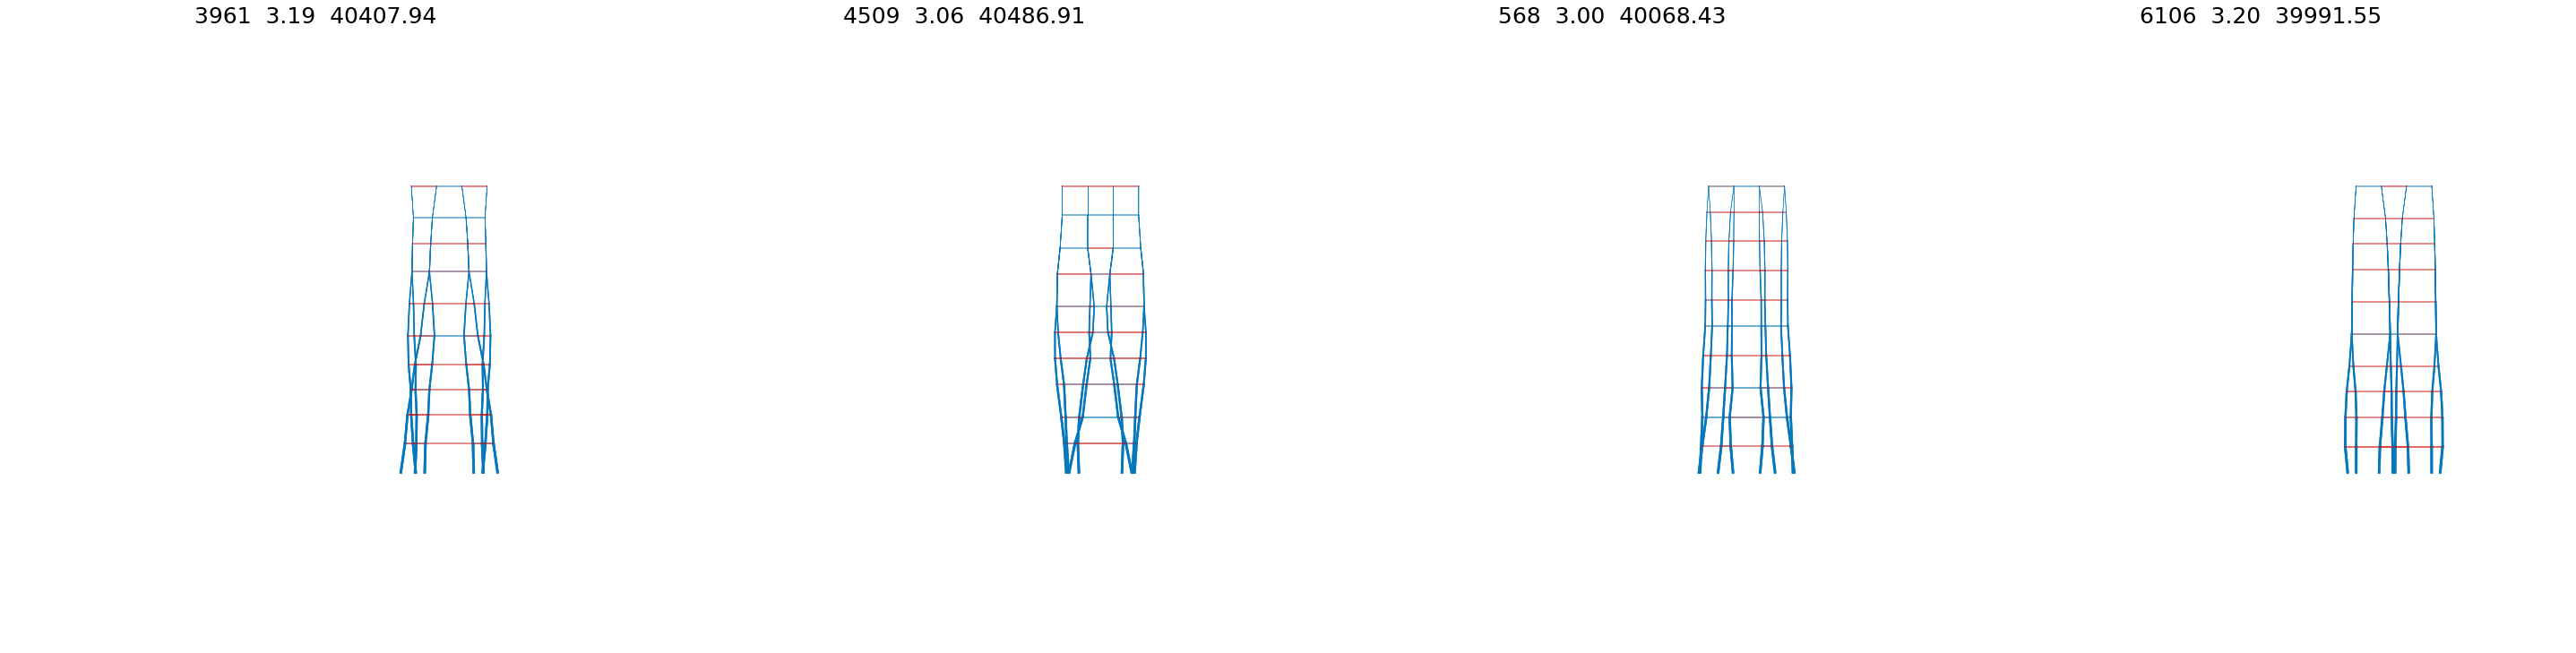

In [152]:
show_node(node_SOM=100, Measure1='devLen_mean', Measure2='totLP')

In [ ]:
# Split DataFrame in train and test with Numpy and Scikit-learn

from sklearn.model_selection import train_test_split

X = input_data_filter.values # set input
Y = data_flat_filter[['totLP']].values # set output

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1)

print("Number elements in train set: "+str(len(Y_train)))
print("Number elements in test set: "+str(len(Y_test)))

In [ ]:
# Standardize X with Numpy and Scikit-learn

from sklearn.preprocessing import StandardScaler

ss = StandardScaler() 
ss.fit(X_train)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

ss.fit(Y_train)
Y_train = ss.fit_transform(Y_train).ravel()
Y_test = ss.transform(Y_test).ravel()

In [ ]:
# Multi-layer Perceptron Regressor

from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(activation='relu', solver='adam', alpha=1e-6, hidden_layer_sizes=(80,120,180,220,260,220,180,100,80,60,40), max_iter=3000, random_state=0, verbose=False)

mlpr.fit(X_train, Y_train)

# y_pred_train = mlpr.predict(X_train)
# y_pred = mlpr.predict(X_test)

score_train = mlpr.score(X_train, Y_train)
score_test = mlpr.score(X_test, Y_test)
    
print("SCORE R2: TRAIN=%.4f TEST=%.4f" % (score_train,score_test))